In [1]:
from __future__ import division
from IPython.display import clear_output
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display
import random

%load_ext autoreload
%autoreload 2

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O85KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# To transform pixel matrix to a single vector.
def getState(inState):
    # each row is all 1 color
    rgbRows = np.reshape(inState,(len(inState[0])*len(inState), 3)).T

    # add each with appropriate shifting
    # get RRRRRRRR GGGGGGGG BBBBBBBB
    return np.add(np.left_shift(rgbRows[0], 16),
        np.add(np.left_shift(rgbRows[1], 8), rgbRows[2]))



In [2]:
from tpg.trainer import Trainer
from tpg.agent import Agent
from tpg.gridworld import GridWorld
from tpg.qlearner import QLearner
from tpg.memory import Memory, get_memory
from tpg.configurations import DefaultConfiguration
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pprint import pprint

In [3]:
customConfig = DefaultConfiguration()
customConfig.teamPopSize = 100
customConfig.memorySize = 25

numGenerations = 25
memory = Memory(customConfig.memorySize)

In [4]:
qLearner = QLearner(25, 2, 0.8, 0.001)
epsilon = 0.15

In [5]:
def detect_changes(predecessor, successor):
    return [1 if pred != succ else 0 for pred, succ in zip(predecessor, successor)]

list_a = [0, 0, 0, 0]
list_b = [1, 0, 1, 1]

diff = detect_changes(list_a, list_b)
print(diff)

[1, 0, 1, 1]


In [6]:
env = gym.make('CartPole-v1', render_mode='rgb_array') # make the environment

print(env.action_space) # learn size of action space

Discrete(2)


In [ ]:
trainer = Trainer(actions=range(2), config=customConfig)
memory.memory_reset()

rewardStats = []

#print("Registers:")
#print(get_memory().registers)
previousState = memory.registers

for generation in range(numGenerations):
    
    rewards = [] # new list every gen
    
    agents = trainer.getAgents()
    
    while True:     
        teamNum = len(agents)
        agent = agents.pop()
                
        if agent is None:
            break # no more agents, proceed to next gen
        
        state = env.reset()[0]
        
        
        score = 0
        
        
        i = 0
        
        print(f"Gen #{generation}, Team #{teamNum}")

        memory.step = 0
        isTerminal = False
        isTruncated = False
        while not isTerminal and not isTruncated and i < 500:
            memory.step += 1
            
            i += 1
            
            #env.display()      
        
            
            memory.buffer_reset()
            
            
            #print("Pre-update global memory")
            #print(get_memory().registers)
                
            programs = agent.getPrograms()
            
            winning_program_id = agent.act(state)
            
            #get_memory().display()
            
            #print(programs, "Winner:", winning_program_id)
            
            before_memory_update = memory.registers
            
            memory.commit(program_id=winning_program_id)
            
            after_memory_update = memory.registers
            
            nextState = detect_changes(before_memory_update, after_memory_update)
            #print("Changes:")
            #print(nextState)
            
            #print("Updated global memory:")
            
            #print(get_memory().registers)
            #print()
            
            #if tpg_response is None:
             #   action = 
            #else:
            #    action = np.argmax(tpg_response)
            
            if generation < 2:
                action = np.random.randint(2)
            else:
                if np.random.random() < epsilon:
                    action = np.random.randint(2)
                else:
                    action = qLearner.predict(previousState).argmax()
                
            
            action = np.random.randint(2)
            
            state, reward, isTerminated, isTruncated, _ = env.step(action)
            
            score += reward
            
            #print(previousState, action, reward, nextState)
            
            if generation >= 2:
                """
                print("Previous state")
                print(previousState)
                print("Next state")
                print(nextState)
                print(f"Action selected: {action}, Reward: {reward}")
                """
                qLearner.train(previousState, nextState, reward, action)
            
            previousState = nextState
            
            if isTerminated or isTruncated:
                break
        
        if i == 500:
            print("Ran out of turns... giving up")
        
       
        #get_memory().display()
        #print(get_memory().registers)
            
        agent.reward(score)
        
        rewards.append(score)

        print(f"Finished after {i} steps with cumulative reward {score}, writes: {memory.writeCount}...")
        # env.display()
        
        if len(agents) == 0:
            break
    
    rewardStats.append((min(rewards), max(rewards), sum(rewards)/len(rewards)))
    trainer.evolve()
    
    memory.generation += 1

Gen #0, Team #100
Finished after 13 steps with cumulative reward 13.0, writes: 53597...
Gen #0, Team #99
Finished after 26 steps with cumulative reward 26.0, writes: 53623...
Gen #0, Team #98
Finished after 23 steps with cumulative reward 23.0, writes: 53646...
Gen #0, Team #97
Finished after 52 steps with cumulative reward 52.0, writes: 53698...
Gen #0, Team #96
Finished after 30 steps with cumulative reward 30.0, writes: 53728...
Gen #0, Team #95
Finished after 21 steps with cumulative reward 21.0, writes: 53749...
Gen #0, Team #94
Finished after 13 steps with cumulative reward 13.0, writes: 53762...
Gen #0, Team #93
Finished after 25 steps with cumulative reward 25.0, writes: 53787...
Gen #0, Team #92
Finished after 16 steps with cumulative reward 16.0, writes: 53803...
Gen #0, Team #91
Finished after 9 steps with cumulative reward 9.0, writes: 53812...
Gen #0, Team #90
Finished after 17 steps with cumulative reward 17.0, writes: 53829...
Gen #0, Team #89
Finished after 18 steps wit

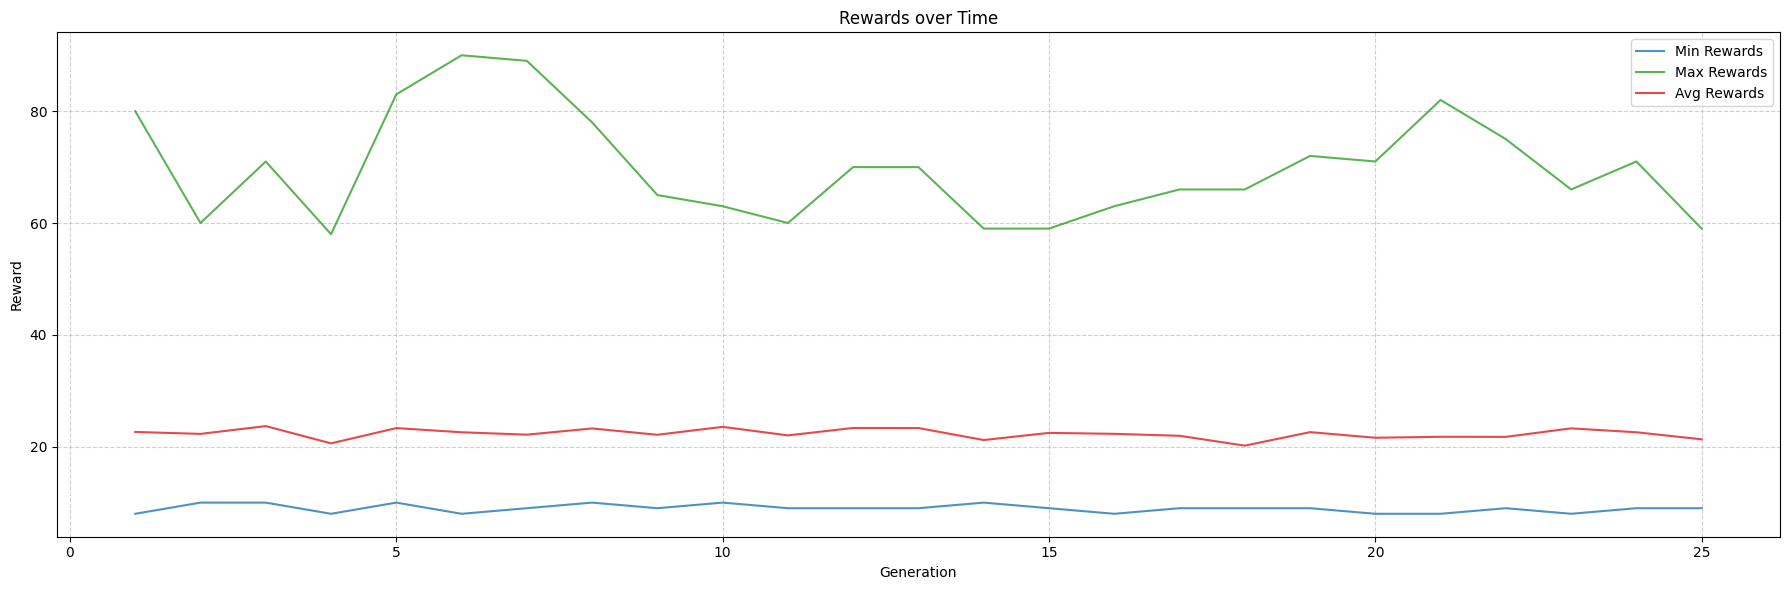

In [8]:
rewardInfo = np.array(rewardStats)

min_rewards = rewardInfo[:, 0]
max_rewards = rewardInfo[:, 1]
avg_rewards = rewardInfo[:, 2]


# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))


# Plot rewards over time
episodes = range(1, len(min_rewards) + 1)
axes.plot(episodes, min_rewards, label='Min Rewards', color='#1f78b4', alpha=0.8)
axes.plot(episodes, max_rewards, label='Max Rewards', color='#33a02c', alpha=0.8)
axes.plot(episodes, avg_rewards, label='Avg Rewards', color='#e31a1c', alpha=0.8)
axes.set_title('Rewards over Time')
axes.set_xlabel('Generation')
axes.set_ylabel('Reward')
axes.legend(loc='upper right')
axes.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()